In [1]:
%load_ext autoreload
%autoreload 2

import sympy as sm
from sympy import pi
import sympy.physics.mechanics as me
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from semiflex import SemiFlexBody
from numba import jit 
me.init_vprinting(use_latex="mathjax")

In [2]:
def smaa(expression,small_angle):
    """Small angle approximation cos and sin"""
    return expression.replace(
        lambda e: e.func == sm.sin and e.args[0] == small_angle,
        lambda e: e.args[0]
    ).replace(
        lambda e: e.func == sm.cos and e.args[0] == small_angle,
        lambda e: 1
    )

In [3]:
def flat(nested_list):
    """Flattens a list of lists into a single list."""
    return [item for sublist in nested_list for item in sublist]

In [ ]:
t = me.dynamicsymbols._t
# masses
m_nac, m_rot = sm.symbols("m_nac,m_rot")
# distances
xn_cm, zn_cm, h_t, h_t_cm, d_nac_rot, d_rot_bld, b_cm = sm.symbols(
    "xn_cm, zn_cm,h_t, h_t_cm,d_nr,d_rb,b_cm"
)

# fixed angles
alpha_tilt, beta = sm.symbols("alpha,beta")
z, g = sm.symbols("z,g")
m_b, k_b, c_b = sm.symbols("m_b,k_b,c_b")
c_quad = sm.symbols("c_quad")
# Inertias
Ixx_n, Iyy_n, Izz_n, Ixx_r, Iyy_r, Izz_r = sm.symbols("Ixx_n,Iyy_n,Izz_n,Ixx_r,Iyy_r,Izz_r")
# Torques and Forces
force_wind, torque_wind, torque_gen = sm.symbols("F_wind,T_w,T_g")

q5, u5 = me.dynamicsymbols("q5,u5")

E = me.ReferenceFrame("E")  # Earth
## Points
og = me.Point("O")
og.set_vel(E, 0)

tower = SemiFlexBody(E, og, "tower", zcm=h_t_cm, dof_x=2, dof_y=2)
q1, q2, q3, q4 = tower.q
u1, u2, u3, u4 = tower.u

N = me.ReferenceFrame("N")  # Nacelle, rotated by tower deformations
N.orient_body_fixed(E, (tower.theta_y, tower.theta_x, 0), "XYZ")

# Rotor, tilted by a fixed amount and rotated by azimuth - normal rotor motion
R = me.ReferenceFrame("R")
# R.orient_body_fixed(E, (alpha_tilt, q5, 0), "YXZ")
# R.set_ang_vel(R, u5 * R.x)
R.orient_body_fixed(N, (alpha_tilt, q5, 0), "YXZ")
R.set_ang_vel(N, u5 * N.x)

B1 = me.ReferenceFrame("B1")
B2 = me.ReferenceFrame("B2")
B3 = me.ReferenceFrame("B3")

B1.orient_axis(R, beta, R.y)
B2.orient_body_fixed(R, (beta, 2 * pi / 3, 0), "YXZ")
B3.orient_body_fixed(R, (beta, 4 * pi / 3, 0), "YXZ")

nacelle_cm = og.locatenew("nac_cm", h_t * E.z + zn_cm*N.z + xn_cm*N.x + (q1 + q2)*E.x  + (q3 + q4) * E.y)
# nacelle_cm = og.locatenew("nac_cm", h_t * E.z + zn_cm * N.z + (q1 + q2 + xn_cm) * N.x)
rotor_cm = nacelle_cm.locatenew("rot_cm", -d_nac_rot * R.x)

b1 = rotor_cm.locatenew("b1", d_rot_bld * B1.z)
b2 = rotor_cm.locatenew("b2", d_rot_bld * B2.z)
b3 = rotor_cm.locatenew("b3", d_rot_bld * B3.z)

blade1 = SemiFlexBody(
    B1, b1, "B1", zcm=b_cm, dof_x=1, var_start=6, uniform_m=m_b, uniform_k=k_b, uniform_damp=c_b
)
blade2 = SemiFlexBody(
    B2, b2, "B2", zcm=b_cm, dof_x=1, var_start=7, uniform_m=m_b, uniform_k=k_b, uniform_damp=c_b
)
blade3 = SemiFlexBody(
    B3, b3, "B3", zcm=b_cm, dof_x=1, var_start=8, uniform_m=m_b, uniform_k=k_b, uniform_damp=c_b
)

blades = (blade1, blade2, blade3)

q6, q7, q8 = blade1.q[0], blade2.q[0], blade3.q[0]
u6, u7, u8 = blade1.u[0], blade2.u[0], blade3.u[0]

I_nacelle = me.inertia(N, Ixx_n, Iyy_n, Izz_n)
I_rotor = me.inertia(N, Ixx_r, Iyy_r, Izz_r)

nacelle = me.RigidBody("nacelle", nacelle_cm, N, m_nac, (I_nacelle, nacelle_cm))
rotor = me.RigidBody("rotor", rotor_cm, R, m_rot, (I_rotor, rotor_cm))
v_rot_x = rotor_cm.vel(E).dot(E.x) # rotor x velocity
quad_damp_force = sm.simplify(-c_quad * sm.Abs(v_rot_x) * v_rot_x)
loads = [
    # (tower_cm,   -m_t * g * E.z),
    (rotor_cm, quad_damp_force * E.x), # quad force
    (rotor_cm, -m_rot * g * E.z),
    (rotor_cm, force_wind * E.x),
    (nacelle_cm, -m_nac * g * E.z),
    (R, torque_wind * R.x), 
    (R, -torque_gen * R.x), 
    (N, torque_gen * R.x), 
]
## add tower contribution to loads and bodies
blade_bodies = flat([b.get_bodies() for b in blades])
bodies = [nacelle, rotor] + tower.get_bodies() + blade_bodies

blade_gravity = [(pb.masscenter, -pb.mass * E.z) for pb in blade_bodies]
blade_loads = flat([b.loads for b in blades])
loads = loads + tower.loads + blade_gravity + blade_loads

coordinates = [q1, q2, q3, q4, q5, q6, q7, q8]
speeds = [u1, u2, u3, u4, u5, u6, u7, u8]
# 2. Lambdify for fast evaluation
state_syms = coordinates + speeds
ext_forces = [force_wind, torque_wind, torque_gen]

kin_eqs = [
    q1.diff(t) - u1,
    q2.diff(t) - u2,
    q3.diff(t) - u3,
    q4.diff(t) - u4,
    q5.diff(t) - u5,
    q6.diff(t) - u6,
    q7.diff(t) - u7,
    q8.diff(t) - u8,
]
nacelle_cm.v1pt_theory(og, E, E)
# # 5. Set up Kane’s method
KM = me.KanesMethod(E, q_ind=coordinates, u_ind=speeds, kd_eqs=kin_eqs)

# # # 4) form the equations
fr, frstar = KM.kanes_equations(bodies=bodies, loads=loads)

/home/lorenzo/miniconda3/envs/openfast/lib/python3.12/site-packages/sympy/physics/vector/point.py:577: UserWarning: 
Velocity of nac_cm automatically calculated based on point O but it is
also possible from points(s): [rot_cm]. Velocities from these points
are not necessarily the same. This may cause errors in your
calculations.
  warn(filldedent(f"""


In [6]:
freesyms = KM.forcing_full.free_symbols | KM.mass_matrix_full.free_symbols

freesyms-tower.free_symbols # actual free symbols outside the tower

{F_wind, Ixxₙ, Ixxᵣ, Iyyₙ, Iyyᵣ, Izzₙ, Izzᵣ, T_g, T_w, α, b_cm, β, c_b, c_quad ↪

↪ , dₙᵣ, d_rb, g, k_b, m_b, m_nac, mᵣₒₜ, t, xn_cm, zn_cm}

In [7]:
all_free_symbols = (KM.mass_matrix_full.free_symbols | KM.forcing_full.free_symbols) - set(ext_forces +[me.dynamicsymbols._t])

sorted_syms = sorted([str(x) for x in all_free_symbols])
print({k: 0.0 for k in sorted_syms}) # to create a placeholder for subs_num

{'Ixx_n': 0.0, 'Ixx_r': 0.0, 'Iyy_n': 0.0, 'Iyy_r': 0.0, 'Izz_n': 0.0, 'Izz_r': 0.0, 'alpha': 0.0, 'b_cm': 0.0, 'beta': 0.0, 'c_b': 0.0, 'c_quad': 0.0, 'c_xTO_1': 0.0, 'c_xTO_2': 0.0, 'c_yTO_1': 0.0, 'c_yTO_2': 0.0, 'd_nr': 0.0, 'd_rb': 0.0, 'g': 0.0, 'k_b': 0.0, 'k_xTO_1': 0.0, 'k_xTO_2': 0.0, 'k_yTO_1': 0.0, 'k_yTO_2': 0.0, 'm_b': 0.0, 'm_nac': 0.0, 'm_rot': 0.0, 'm_xTO_1': 0.0, 'm_xTO_2': 0.0, 'm_yTO_1': 0.0, 'm_yTO_2': 0.0, 'r_xTO_1': 0.0, 'r_xTO_2': 0.0, 'r_yTO_1': 0.0, 'r_yTO_2': 0.0, 'xn_cm': 0.0, 'zn_cm': 0.0}


In [7]:
k1, k2 = 20e6, 2336e6
mt1, mt2 = 710_000, 332_000
r_1t = 0.0185
r_2t = 0.268

# Damping coefficients
c_damp1 = 0.009 * 2 * np.sqrt(mt1 * k1)
c_damp2 = 0.02 * 2 * np.sqrt(mt2 * k2)

#blades
m_b = 17_740  # kg
k_b = 2.43e6
c_b = 2 * 0.02 * np.sqrt(k_b * m_b)

subs_num = {
    "Ixx_n": 3.23e6,
    "Ixx_r": 1.93e5,
    "Iyy_n": 3.07e6,
    "Iyy_r": 1.93e5,
    "Izz_n": 2.61e6,
    "Izz_r": 1.93e5,
    "alpha": np.deg2rad(5),  # assuming this corresponds to alpha_tilt
    "b_cm": 27.46,  # meters,            
    "beta": np.deg2rad(2.5),             
    "c_b": c_b,             
    "c_xTO_1": c_damp1,
    "c_xTO_2": c_damp2,
    "c_yTO_1": c_damp1,
    "c_yTO_2": c_damp2,
    "d_rb": 5,               # assuming this corresponds to d_nac_rot
    "g": 9.81,
    "k_b": k_b,             
    "k_xTO_1": k1,
    "k_xTO_2": k2,
    "k_yTO_1": k1,
    "k_yTO_2": k2,
    "m_b": m_b,              
    "m_nac": 240_000,
    "m_rot": 56_000,
    "m_xTO_1": mt1,
    "m_xTO_2": mt2,
    "m_yTO_1": mt1,
    "m_yTO_2": mt2,
    "r_xTO_1": r_1t,
    "r_xTO_2": r_2t,
    "r_yTO_1": r_1t,
    "r_yTO_2": r_2t,
    "xn_cm": 1.9,
    "zn_cm": 1.75,
}


In [10]:
# 1. Substitute values

M_num = KM.mass_matrix_full.subs(subs_num)
F_num = KM.forcing_full.subs(subs_num)

M_num_sma = smaa(smaa(KM.mass_matrix_full,tower.theta_y),tower.theta_x).subs(subs_num)
F_num_sma = smaa(smaa(KM.forcing_full,tower.theta_y),tower.theta_x).subs(subs_num)

#numexpr, cython, numpy

M_func = sm.lambdify(state_syms, M_num, 'numpy')
F_func = sm.lambdify(state_syms+ext_forces, F_num, 'numpy')

M_func_sma = sm.lambdify(state_syms, M_num_sma, 'numpy')
F_func_sma = sm.lambdify(state_syms+ext_forces, F_num_sma, 'numpy')

In [11]:
R = 50
omega_max = 12

def rhs(t, y,ws=0):
    omega = y[12]
    f_wind = thrust_force_jit(R,ws)
    t_wind = rotor_torque_jit(R,ws,omega)
    t_gen = generator_torque_control(t_wind,omega,omega_max,k_p=0.1)
    M = M_func(*y)
    F = F_func(*y,f_wind,t_wind,t_gen).flatten()
    # M = M_func_sma(*y)
    # F = F_func_sma(*y,f_wind,t_wind,t_gen).flatten()
    return np.linalg.solve(M, F)

In [12]:
%%time
m = M_func(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)
f = F_func(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)

CPU times: user 1.97 ms, sys: 0 ns, total: 1.97 ms
Wall time: 1.98 ms


In [13]:
# import cProfile
# cProfile.run('solve_ivp(rhs, t_span, y0, args=(wind_speed,))')

In [14]:
# 4. Integrate
t_span = (0, 15)
y0 = [0.5,0,0.1,0,0,0,0,0,0,0,0,0,0,0,0,0] 

wind_speed = 10
sol = solve_ivp(rhs, t_span, y0,args=(wind_speed,))

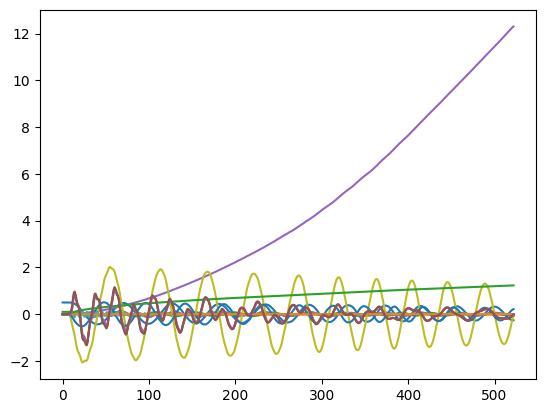

In [15]:
plt.plot(sol.y.T)
plt.show()

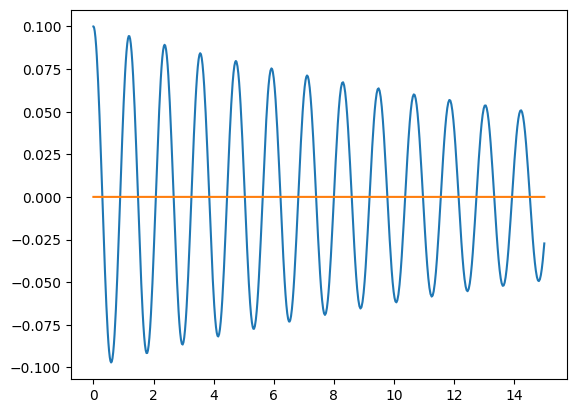

In [23]:
plt.plot(sol.t,sol.y.T[:,2:4])
plt.show()

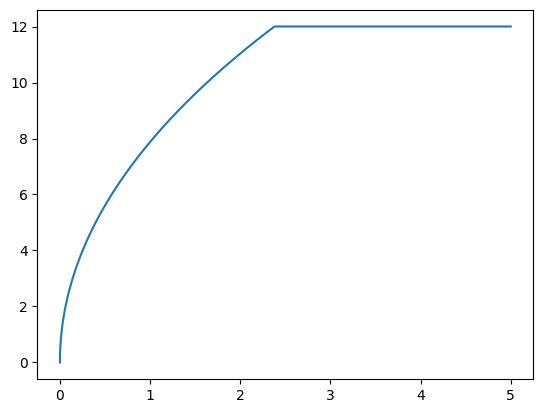

In [87]:
plt.plot(sol.t,sol.y.T[:,9])
plt.show()

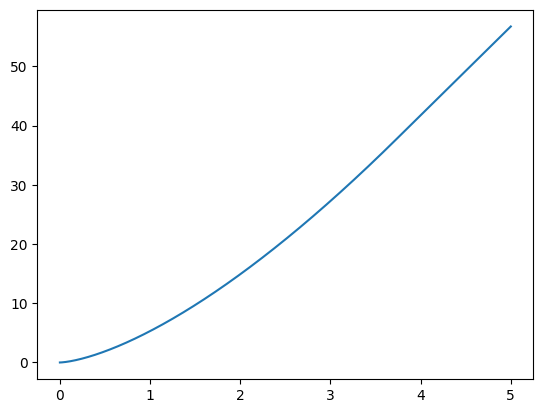

In [51]:
plt.plot(sol.t,sol.y.T[:,4])
plt.show()

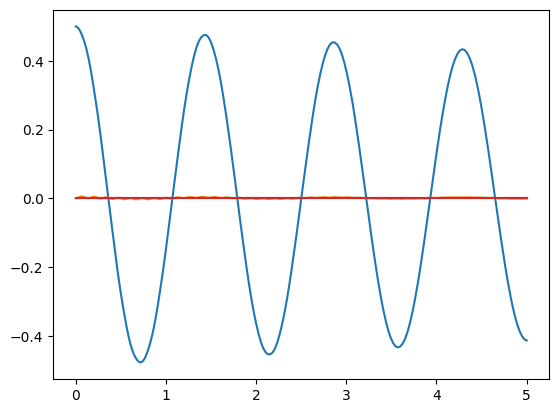

In [94]:
plt.plot(sol.t,sol.y.T[:,:4])
plt.show()

In [8]:
import pickle

results_to_save = {
    'mass_full': KM.mass_matrix_full,
    'forcing_full': KM.forcing_full,
    'mass_sma': smaa(smaa(KM.mass_matrix_full,tower.theta_y),tower.theta_x),
    'forcing_sma':smaa(smaa(KM.forcing_full,tower.theta_y),tower.theta_x),
    'coordinates' : coordinates,
    'speeds' : speeds,
    'ext_forces': ext_forces
}

with open('8dof_km_res.pkl', 'wb') as f:
    pickle.dump(results_to_save, f)